In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import numpy as np
import pandas as pd
import os
os.environ["OBJC_DISABLE_INITIALIZE_FORK_SAFETY"] = "YES"


In [3]:
# Build connection
spark = SparkSession.builder. \
    master("local[*]"). \
    appName("PySpark"). \
    config("spark.driver.memory","16g"). \
    config("spark.driver.maxResultSize", "4g"). \
    getOrCreate()

23/04/14 15:18:27 WARN Utils: Your hostname, tiancaimeishaonvs-MacBook.local resolves to a loopback address: 127.0.0.1; using 172.17.115.171 instead (on interface en0)
23/04/14 15:18:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/14 15:18:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load Dataset
data_path = 'data/convincing_data.csv'
data = spark.read.option("header",True).csv(data_path).rdd

In [5]:
data.take(1)

[Row(type='comment', id='imlcpab', subreddit.id='2qh1i', subreddit.name='askreddit', subreddit.nsfw='False', created_utc='1661990065', permalink='https://old.reddit.com/r/AskReddit/comments/x2fj3g/whats_a_controversial_topic_no_one_wants_to/imlcpab/', sentiment='0.469', score='2', body_cleaned="['need', 'chang', 'law', 'worth', 'sell', 'agricultur', 'product', 'us', 'rather', 'export', 'also', 'need', 'chang', 'law', 'monetari', 'penalti', 'grow', 'crop', 'particular', 'viabl', 'area', 'natur', 'climat', 'stand', 'right', 'neighbor', 'make', 'doubl', 'price', 'per', 'head', 'cattl', 'export', 'countri', 'would', 'sell', 'right', 'peopl', 'complain', 'climat', 'chang', 'probabl', 'complain']", climate_count='2', change_count='3', body_length='403', climate_proportion='0.004962779156327543', change_proportion='0.007444168734491315')]

In [6]:
def score_label(score):
    if score>1/3: return 1
    elif score<-1/3: return -1
    else: return 0

In [7]:
id_label_content = data.map(lambda x: (x['id'], score_label(float(x['sentiment'])), x['body_cleaned']))

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluation(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    return accuracy, precision, recall, f1

/Users/zhangyuchen/miniforge3/envs/yuki/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### AFINN lexicon

In [9]:
# !pip install afinn
from afinn import Afinn
afinn = Afinn()
id_label_score_afinn = id_label_content.map(lambda x: (x[0], x[1], afinn.score(x[2])))   
id_true_pred_afinn = id_label_score_afinn.map(lambda x: (x[0], x[1], score_label(x[2])))

In [10]:
%%time
res_afinn = pd.DataFrame(id_true_pred_afinn.collect())
print('Accuracy, Precision, Recall, F1:', evaluation(res_afinn.iloc[:,1],res_afinn.iloc[:,2]))

Accuracy, Precision, Recall, F1: (0.6539647536719038, 0.631317904118818, 0.6539647536719038, 0.6369623941387825)
CPU times: user 909 ms, sys: 93.5 ms, total: 1 s
Wall time: 4min 23s


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

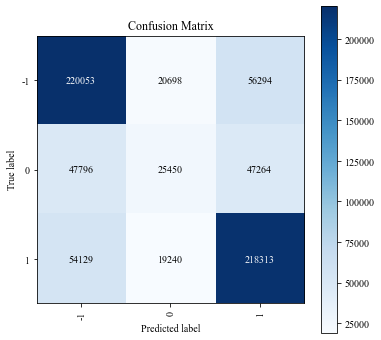

In [52]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    res_afinn.iloc[:,1],res_afinn.iloc[:,2],
    figsize=(6,6),x_tick_rotation=90)

### VADER lexicon

In [11]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
id_label_score_vader = id_label_content.map(lambda x: (x[0], x[1], analyzer.polarity_scores(x[2])['compound']))  
id_true_pred_vader = id_label_score_vader.map(lambda x: (x[0], x[1], score_label(x[2])))


In [12]:
%%time
res_vader = pd.DataFrame(id_true_pred_vader.collect())
print('Accuracy, Precision, Recall, F1:', evaluation(res_vader.iloc[:,1],res_vader.iloc[:,2]))

Accuracy, Precision, Recall, F1: (0.6664034730280569, 0.6857477097045335, 0.6664034730280569, 0.6730803285428608)
CPU times: user 898 ms, sys: 79.8 ms, total: 978 ms
Wall time: 2min 50s


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

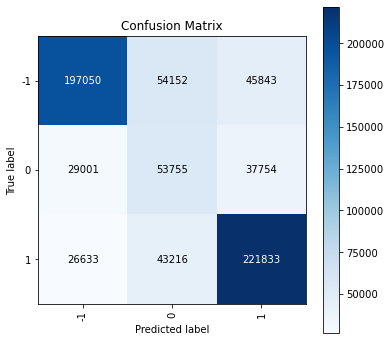

In [42]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    res_vader.iloc[:,1],res_vader.iloc[:,2],
    figsize=(6,6),x_tick_rotation=90)

### Hu and Liu Lexicon

In [13]:
positive_words = pd.read_csv('https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/positive-words.txt',
                        names=['word'], comment=';', encoding='latin-1')['word'].tolist()
negative_words = pd.read_csv('https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/negative-words.txt',
                        names=['word'], comment=';', encoding='latin-1')['word'].tolist()

def get_sentiment_huliu(words):
    # Define variables to keep track of the positive and negative scores
    pos_score = 0
    neg_score = 0
    
    # Loop through each word and check if it's in the positive or negative word list
    for word in words:
        if word in positive_words:
            pos_score += 1
        elif word in negative_words:
            neg_score += 1
    # print(pos_score,neg_score)
    # Calculate the sentiment score for the text
    if pos_score > neg_score:
        return 1
    elif pos_score < neg_score:
        return -1
    else:
        return 0


In [14]:
id_true_pred_huliu = id_label_content.map(lambda x: (x[0], x[1], get_sentiment_huliu(x[2].strip('[]').replace("'",'').split(', '))))


In [15]:
%%time
res_huliu = pd.DataFrame(id_true_pred_huliu.collect())
print('Accuracy, Precision, Recall, F1:', evaluation(res_huliu.iloc[:,1],res_huliu.iloc[:,2]))

Accuracy, Precision, Recall, F1: (0.5874214120244714, 0.5839358539539027, 0.5874214120244714, 0.5855056999041172)
CPU times: user 952 ms, sys: 121 ms, total: 1.07 s
Wall time: 12min 27s


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

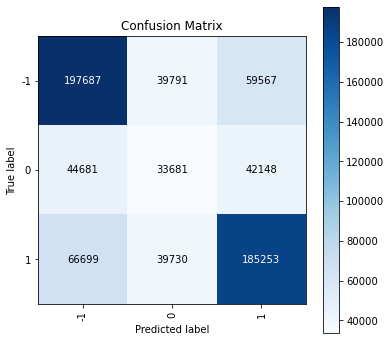

In [43]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    res_huliu.iloc[:,1],res_huliu.iloc[:,2],
    figsize=(6,6),x_tick_rotation=90)

In [27]:
spark.stop()

### SentiWordNet Lexicon

In [15]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize

def get_sentiment_nltk(words):
    pos_score = 0
    neg_score = 0
    obj_score = 0
    for word in words:
        synsets = wn.synsets(word)
        if synsets:
            swn_synset = swn.senti_synset(synsets[0].name())
            pos_score += swn_synset.pos_score()
            neg_score += swn_synset.neg_score()

    # normalize the scores
    if pos_score > neg_score:
        return 1
    elif pos_score < neg_score:
        return -1
    else:
        return 0


In [16]:
data_path = 'data/convincing_data.csv'
data = pd.read_csv(data_path)
data = data[['id','sentiment','body_cleaned']]
data['body_cleaned'] = data['body_cleaned'].apply(lambda x: x.strip('[]').replace("'",'').split(', '))

In [17]:
%%time
data['sentiment_pred'] = data['body_cleaned'].apply(lambda x: get_sentiment_nltk(x))

CPU times: user 13min 7s, sys: 51.7 s, total: 13min 58s
Wall time: 14min 27s


In [18]:
data['sentiment'] = data['sentiment'].apply(lambda x: score_label(x))

In [19]:
print('Accuracy, Precision, Recall, F1:', evaluation(data.iloc[:,1],data.iloc[:,3]))

Accuracy, Precision, Recall, F1: (0.5123139373721337, 0.4875566191997993, 0.5123139373721337, 0.4870587495077113)


## Majority Voting

In [33]:
top3 = pd.concat([res_afinn.iloc[:,1:3],res_vader.iloc[:,2],res_huliu.iloc[:,2]],axis=1)
top3.columns = ['true','a','v','h']

In [36]:
from scipy import stats

top3['vote'] = top3.apply(lambda x: stats.mode([x['a'],x['v'],x['h']])[0][0], axis=1)

In [37]:
print('Accuracy, Precision, Recall, F1:', evaluation(top3['true'],top3['vote']))

Accuracy, Precision, Recall, F1: (0.6714976799010768, 0.6539643712192283, 0.6714976799010768, 0.6583463379408402)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

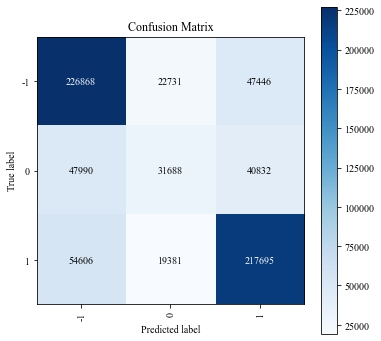

In [51]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    top3['true'],top3['vote'],
    figsize=(6,6),x_tick_rotation=90)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
plt.rcParams['axes.unicode_minus'] = False 